In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
# sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
from fio import readin
# plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')

## Summary:
This notebook analyze the bulk velocity and height etc.
## <a class="anchor" id="0">Table of content: </a> 

#### [1. Height](#1)

### <a class="anchor" id="1">Height</a>

In [ ]:
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_P0020_RE40000_9_30_rand0_noHtheta/diagnosis/bulk/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_P0020_RE40000_9_15_rand4_noHtheta/diagnosis/bulk/'


L = 50; N = 2**9
h_ensem = []; ux_ensem = []; uy_ensem = []

def read (pre='eta_matrix_', index=0, N=512):
    global filepath
    filename = filepath + pre + '%g' %index
    f = np.fromfile(filename, dtype=np.float32)
    f = f.reshape(N+1,N+1); f = f[1:,1:]
    return f

for l in range (0,15):
    h = read(pre='h_matrix_l', index=l, N=N)
    ux = read(pre='ux_matrix_l', index=l, N=N)
    uy = read(pre='uy_matrix_l', index=l, N=N)
    h_ensem.append(h)
    ux_ensem.append(ux)
    uy_ensem.append(uy)
    
h_ensem = np.array (h_ensem)
ux_ensem = np.array (ux_ensem)
uy_ensem = np.array (uy_ensem)

In [71]:
h_surface = np.sum(h_ensem, axis=0)

Text(0, 0.5, '$\\eta$(m)')

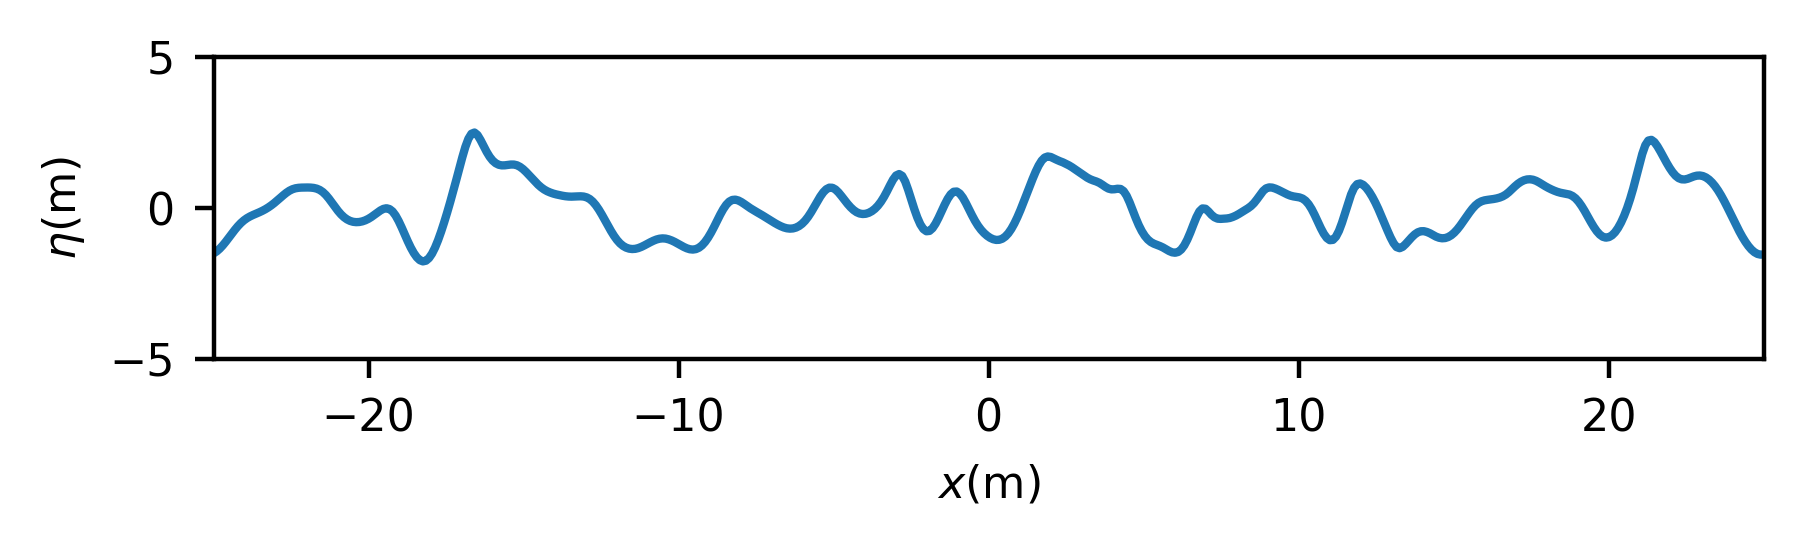

In [84]:
plt.figure(figsize=[5,1])
plt.plot(np.linspace(-25,25,512), h_surface[:,120]-(np.average(h_surface[:,120])))
plt.xlim([-25,25])
plt.ylim([-5,5])
plt.xlabel('$x$(m)')
plt.ylabel(r'$\eta$(m)')

Text(0, 0.5, '$z$')

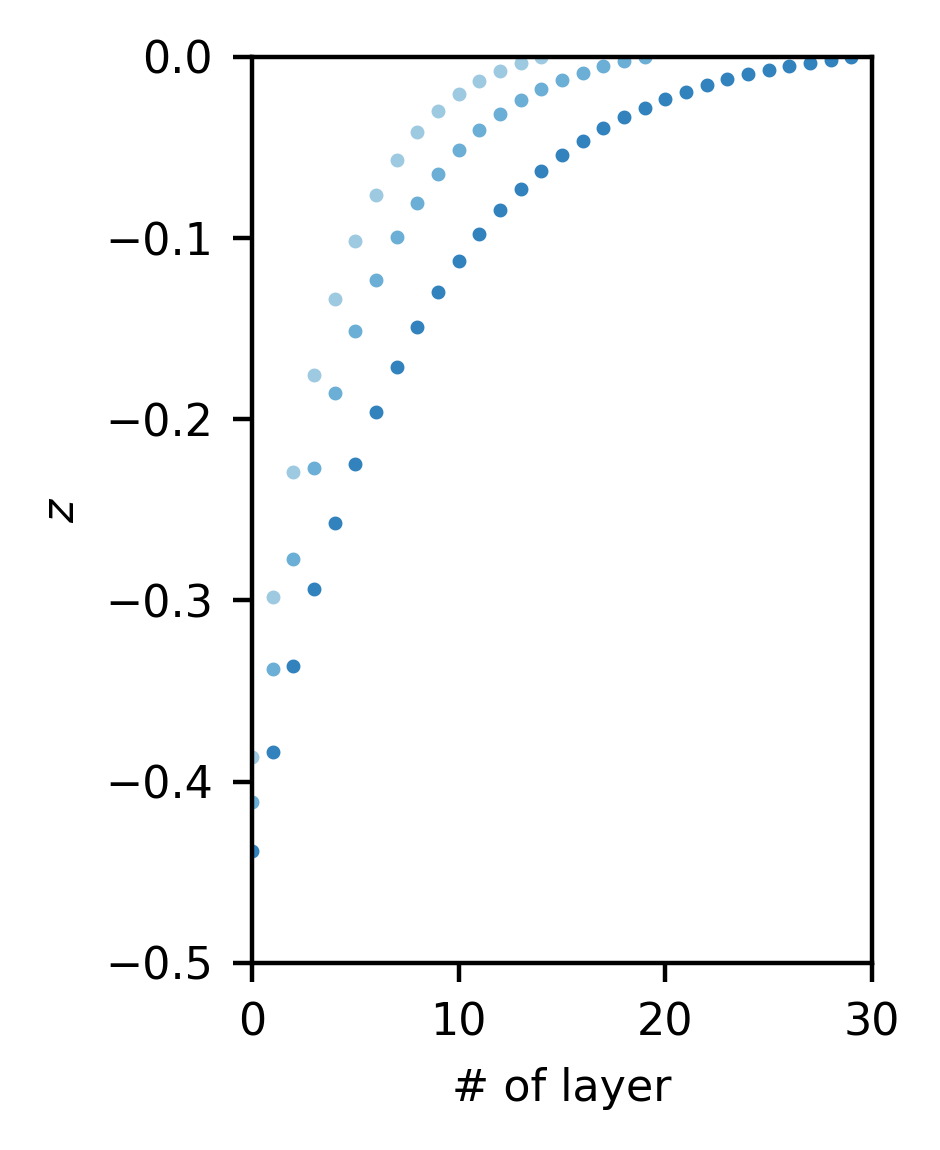

In [31]:
fig = plt.figure(figsize=[2,3])
for (j,case) in enumerate((case1,case2,case3)):
    h_aver = np.average(case.h_ensem, axis=(1,2))
    h_aver[0] = h_aver[1]*h_aver[1]/h_aver[2] # Because of the first layer not detected...
    z_aver = np.zeros(len(h_aver))
    for i in range(len(z_aver)):
        z_aver[i] = np.sum(h_aver[0:i+1]) 
    # plt.plot(h_aver,'.')
    plt.plot(z_aver-0.5,'.',markersize=3, c=plt.cm.get_cmap('tab20c')(j))
# plt.plot(np.var(h_ensem, axis=(1,2))**0.5,'.')
# plt.plot(np.average(ux_ensem, axis=(1,2)),'.')
plt.xlim([0,30])
plt.ylim([-0.5,0])
plt.xlabel('# of layer')
plt.ylabel(r'$z$')

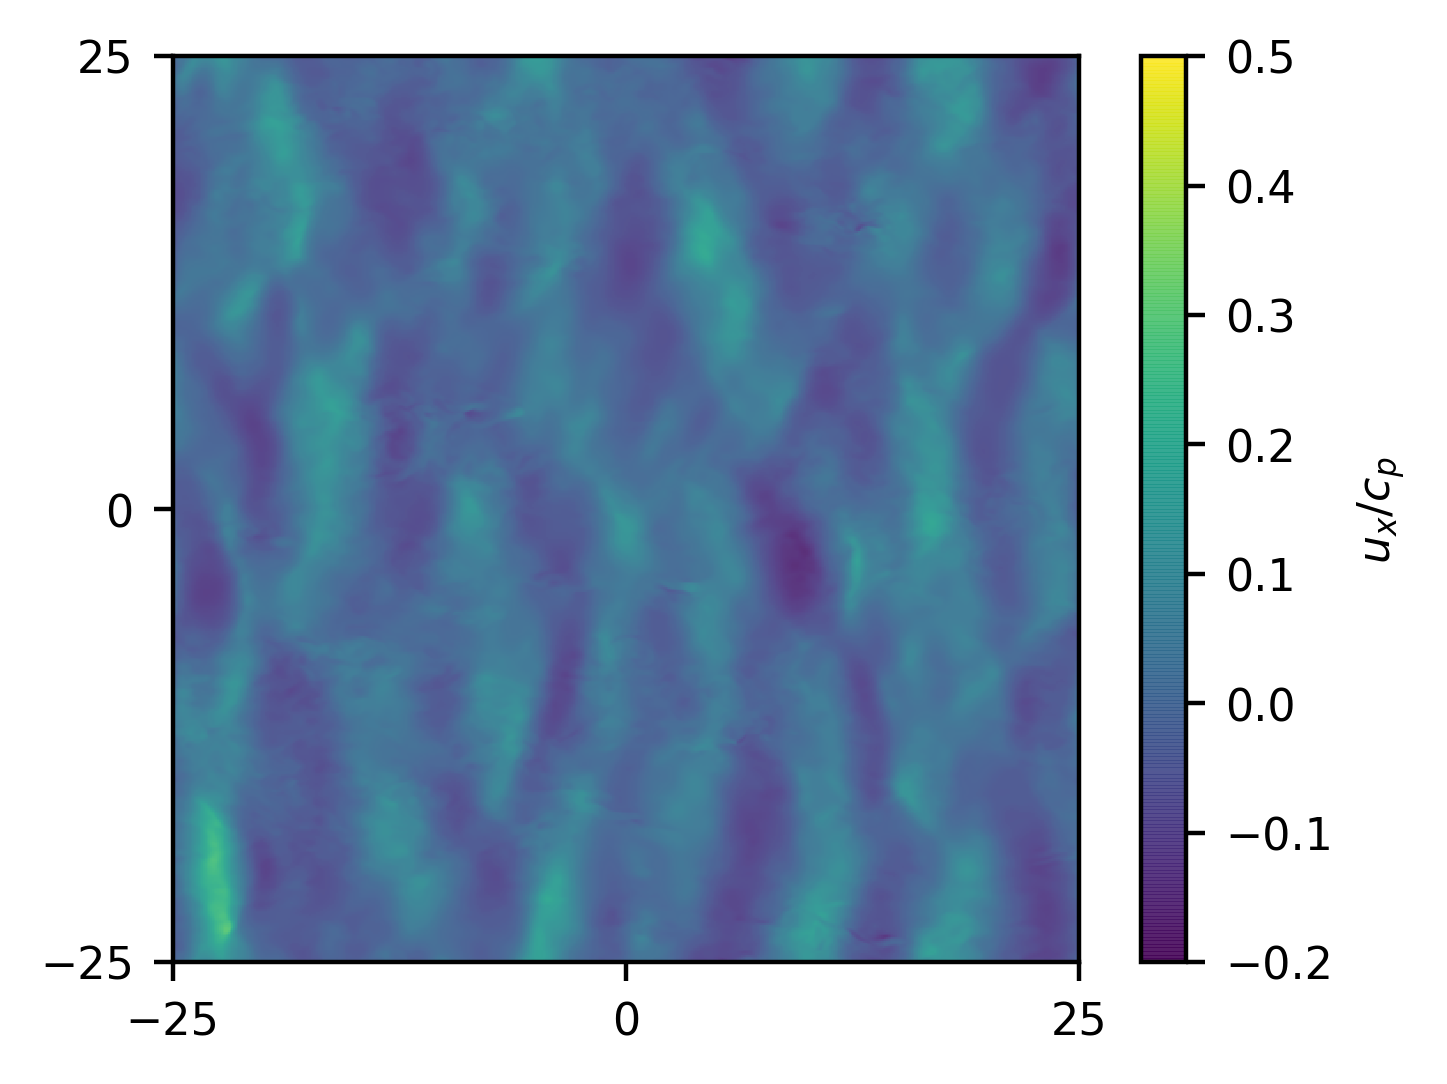

In [41]:
fig = plt.figure(figsize=[4,3]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
image = ax.imshow(np.rot90(ux_ensem[10])/cp, extent=[-L/2,L/2,-L/2,L/2], vmax=0.5, vmin=-0.2, cmap='viridis', alpha=0.9)
ax.set_xticks([-L/2,0,L/2]); ax.set_yticks([-L/2,0,L/2])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x/c_p$')

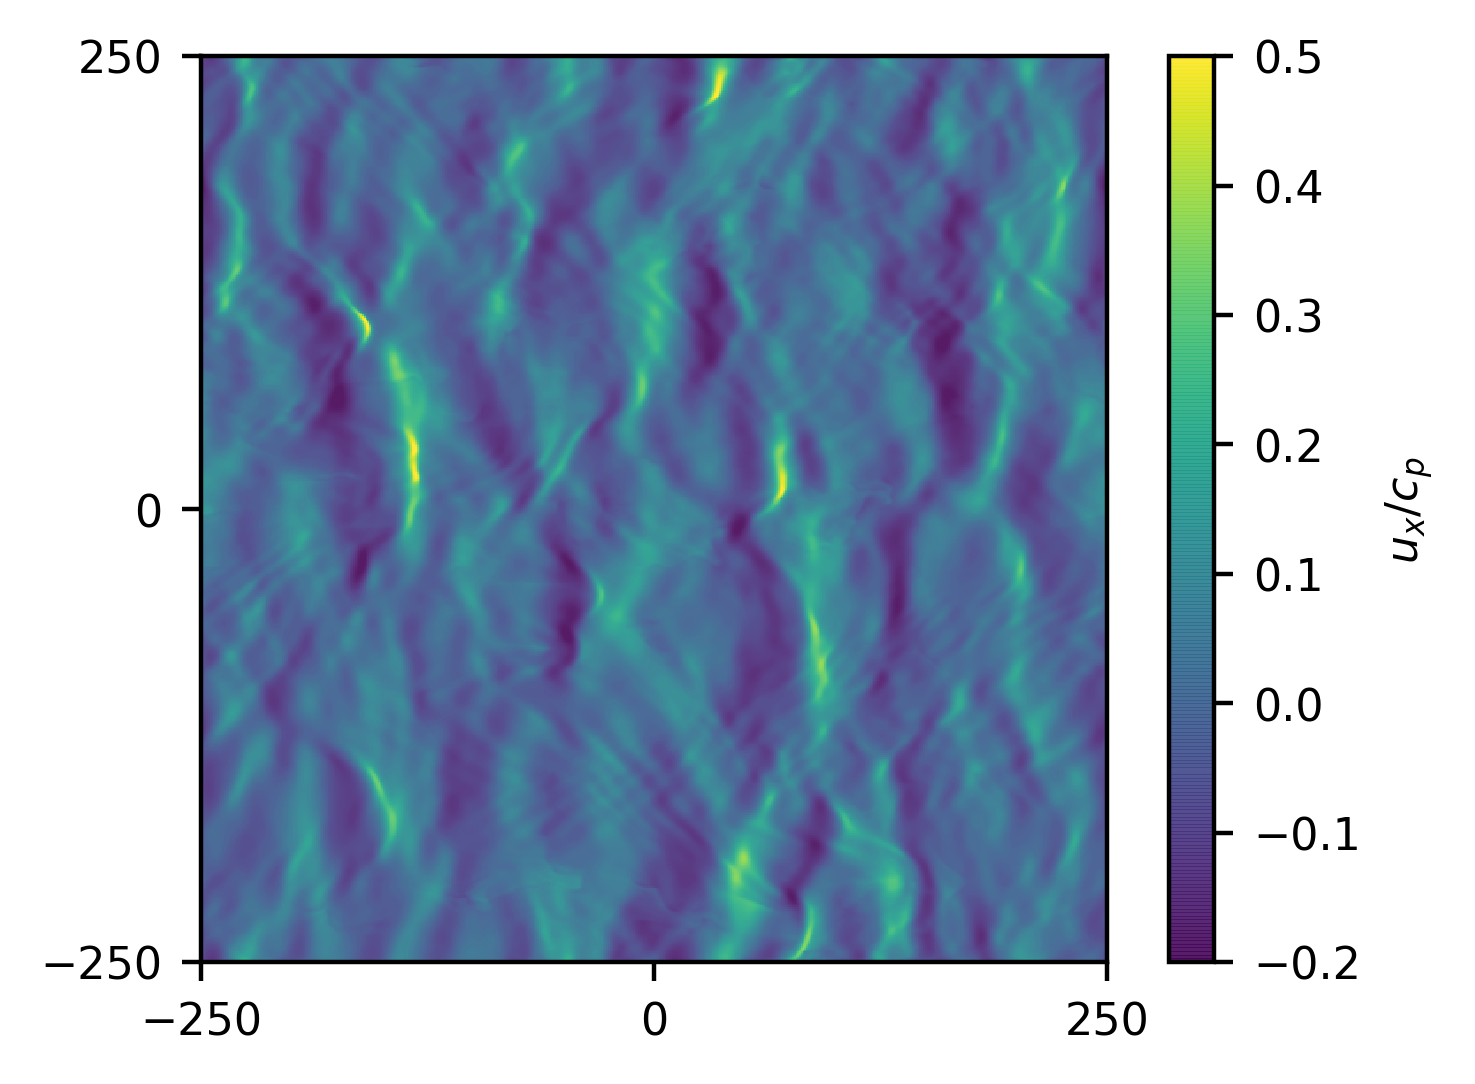

In [75]:
fig = plt.figure(figsize=[4,3]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
image = ax.imshow(np.rot90(ux_ensem[14])/cp, extent=[-L/2,L/2,-L/2,L/2], vmax=0.5, vmin=-0.2, cmap='viridis', alpha=0.9)
ax.set_xticks([-L/2,0,L/2]); ax.set_yticks([-L/2,0,L/2])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x/c_p$')

In [3]:
def read (filepath='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_20_Htheta0.51/field_t5/', pre='eta_matrix_', index=0, N=512):
    filename = filepath + pre + '%g' %index
    f = np.fromfile(filename, dtype=np.float32)
    f = f.reshape(N+1,N+1); f = f[1:,1:]
    return f

class Case(object):
    """ This class defines methods specific to cases.
        Attributes: 
            self.NL 
    """
    def __init__(self, NL=20, LEVEL=8, path='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_20_Htheta0.51/'):
        self.NL = NL 
        self.path = path 
        self.LEVEL = LEVEL
    
    def read_t(self, t=5):
        h_ensem = []; ux_ensem = []; uy_ensem = []; uz_ensem = []
        folder = self.path + 'field_t%g/' %t
        N = 2**self.LEVEL
        for l in range (0,self.NL):
            h = read(filepath=folder, pre='h_matrix_l', index=l, N=N)
            ux = read(filepath=folder, pre='ux_matrix_l', index=l, N=N)
            uy = read(filepath=folder, pre='uy_matrix_l', index=l, N=N)
            uz = read(filepath=folder, pre='uz_matrix_l', index=l, N=N)
            h_ensem.append(h)
            ux_ensem.append(ux)
            uy_ensem.append(uy)
            uz_ensem.append(uz)
        """ axis0-z; axis1-x; aixs2-y"""
        self.h_ensem = np.array (h_ensem)
        self.ux_ensem = np.array (ux_ensem)
        self.uy_ensem = np.array (uy_ensem)
        self.uz_ensem = np.array (uz_ensem)
        return (self.h_ensem, self.ux_ensem, self.uy_ensem, self.uz_ensem)

### 3D reconstruction of the field

In [28]:
case1 = Case(NL=30, LEVEL=8, path='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_30_Htheta0.503/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case1.read_t(t=5)

In [29]:
case2 = Case(NL=20, LEVEL=8, path='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_20_Htheta0.51/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case2.read_t(t=5)

In [30]:
case3 = Case(NL=15, LEVEL=8, path='/projects/DEIKE/jiarongw/multilayer/stokes/stokes_8_15_Htheta0.503/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case3.read_t(t=5)

In [4]:
case_field1 = Case(NL=30, LEVEL=9, path='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_30_rand2_Htheta0.503/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case_field1.read_t(t=120)

In [90]:
case_field1 = Case(NL=30, LEVEL=9, path='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_30_rand2_Htheta0.503/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case_field1.read_t(t=120)

In [4]:
case_field1 = Case(NL=15, LEVEL=9, path='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/')
h_ensem, ux_ensem, uy_ensem, uz_ensem = case_field1.read_t(t=120)

In [ ]:
fig = plt.figure(figsize=[4,3]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
L = 1
image = ax.imshow(np.rot90(ux_ensem[19])/cp, extent=[-L/2,L/2,-L/2,L/2], vmax=1, vmin=-0.2, cmap='viridis', alpha=0.9)
ax.set_xticks([-L/2,0,L/2]); ax.set_yticks([-L/2,0,L/2])
cbar = plt.colorbar(image)
# nx = 415; ny = 30
# ax.plot((nx-N/2)/N*L,(ny-N/2)/N*L,marker='o',markersize=1,c='r')
cbar.set_label(r'$u_x/c_p$')
plt.xlabel('$x$(m)')
plt.ylabel('$y$(m)', labelpad=-10)
# fig.savefig('figures/ux_500m.pdf', bbox_inches='tight', pad_inches=0)

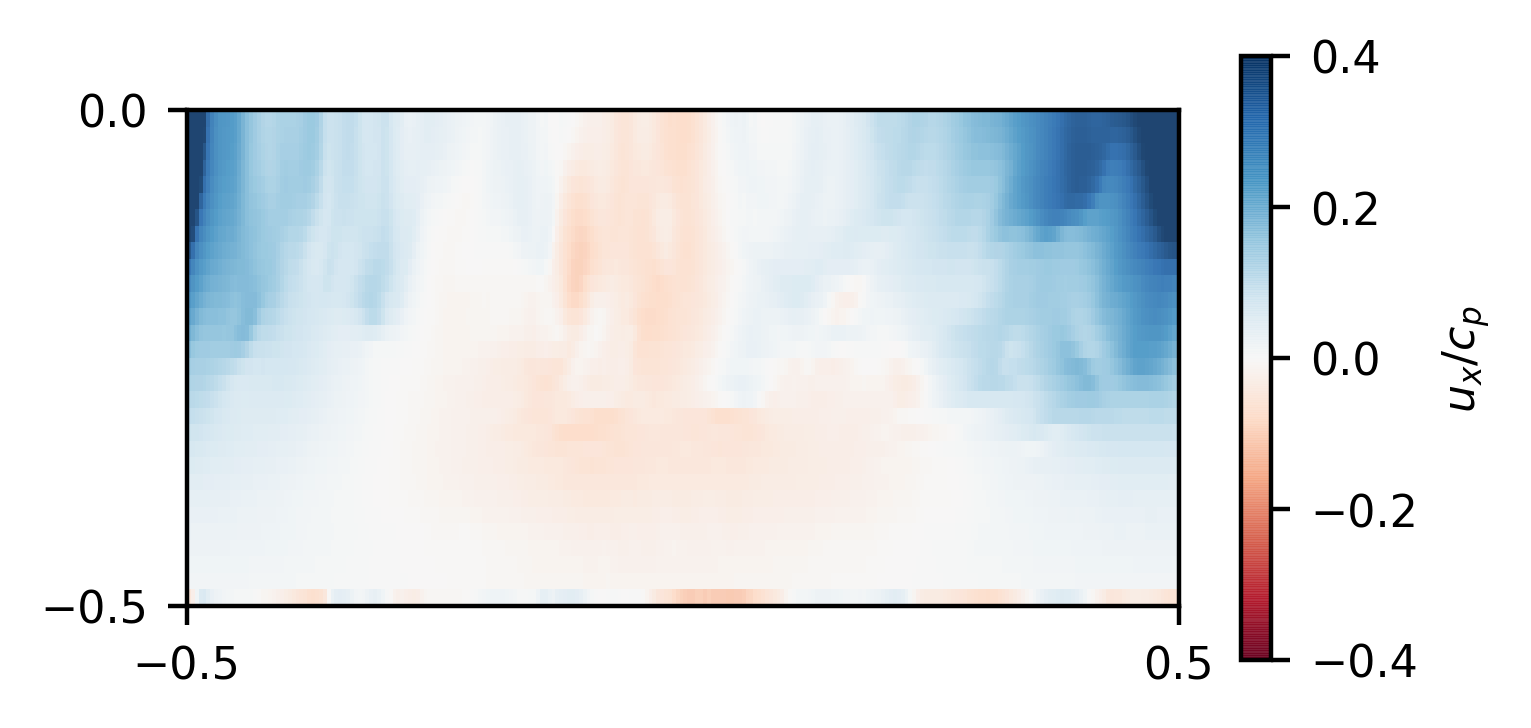

In [37]:
fig = plt.figure(figsize=[4,2]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
L = 1
image = ax.imshow(case1.ux_ensem[::-1,:,30]/cp, extent=[-L/2,L/2,-0.5,0], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)
ax.set_xticks([-L/2,L/2]); ax.set_yticks([-0.5,0])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x/c_p$')

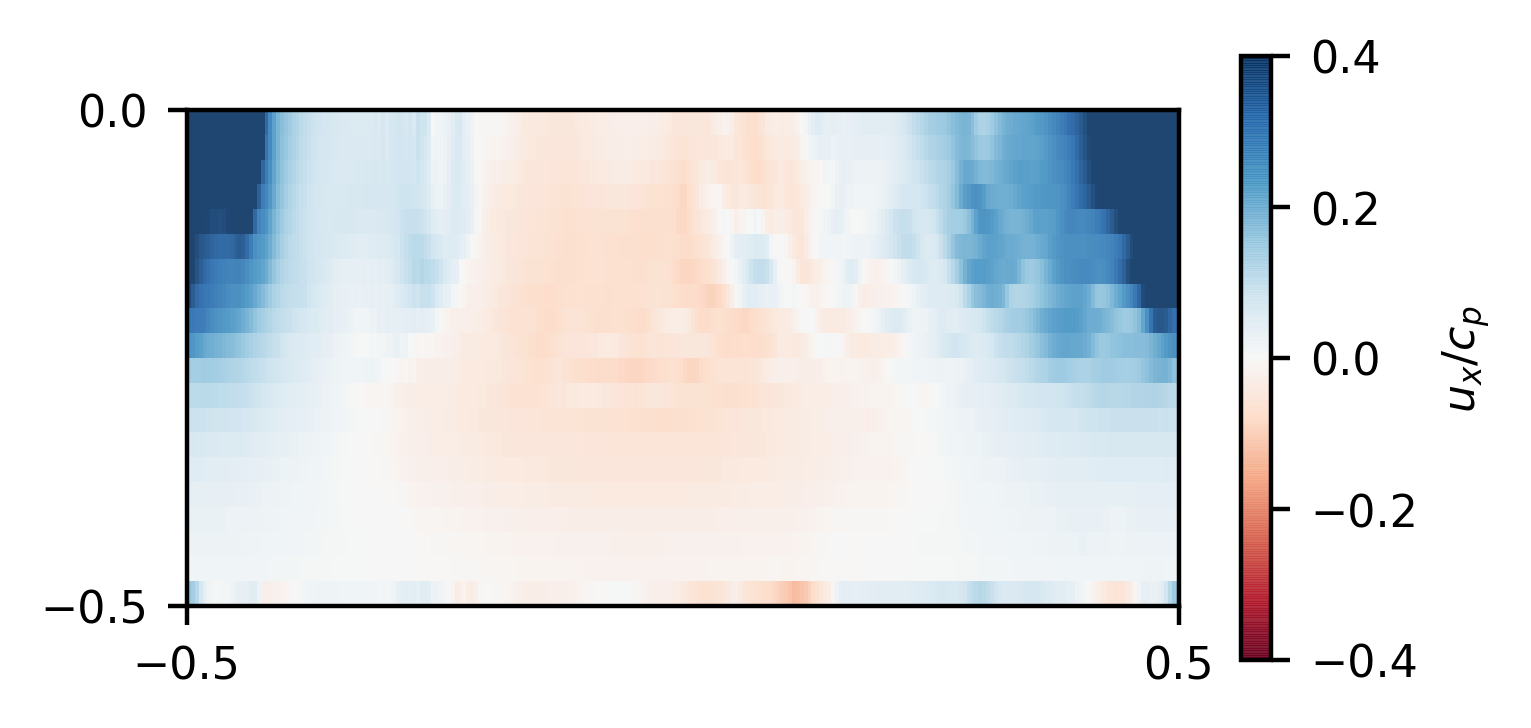

In [35]:
fig = plt.figure(figsize=[4,2]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
image = ax.imshow(case2.ux_ensem[::-1,:,30]/cp, extent=[-L/2,L/2,-0.5,0], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)
ax.set_xticks([-L/2,L/2]); ax.set_yticks([-0.5,0])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x/c_p$')

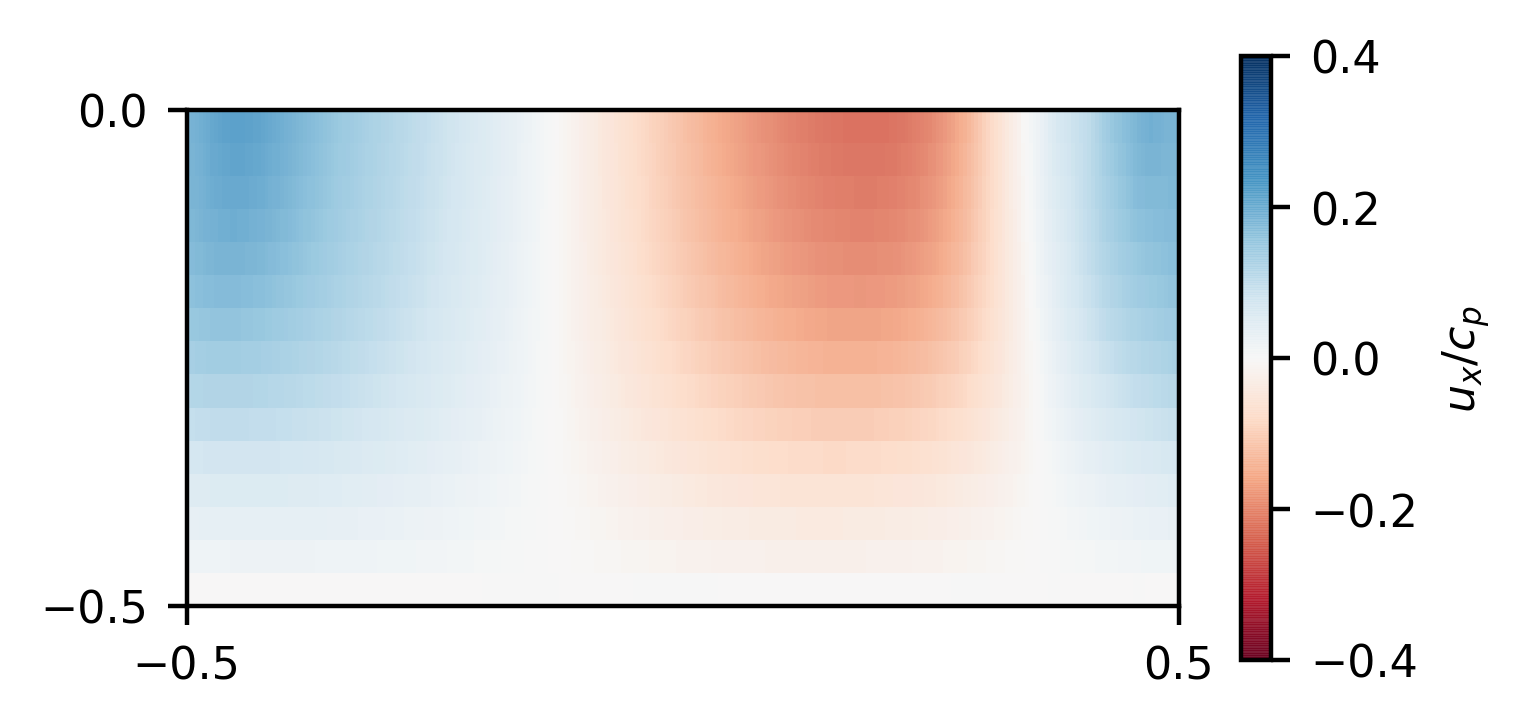

In [36]:
fig = plt.figure(figsize=[4,2]); ax = plt.gca()
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 
image = ax.imshow(case3.uz_ensem[::-1,:,30]/cp, extent=[-L/2,L/2,-0.5,0], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)
ax.set_xticks([-L/2,L/2]); ax.set_yticks([-0.5,0])
cbar = plt.colorbar(image)
cbar.set_label(r'$u_x/c_p$')

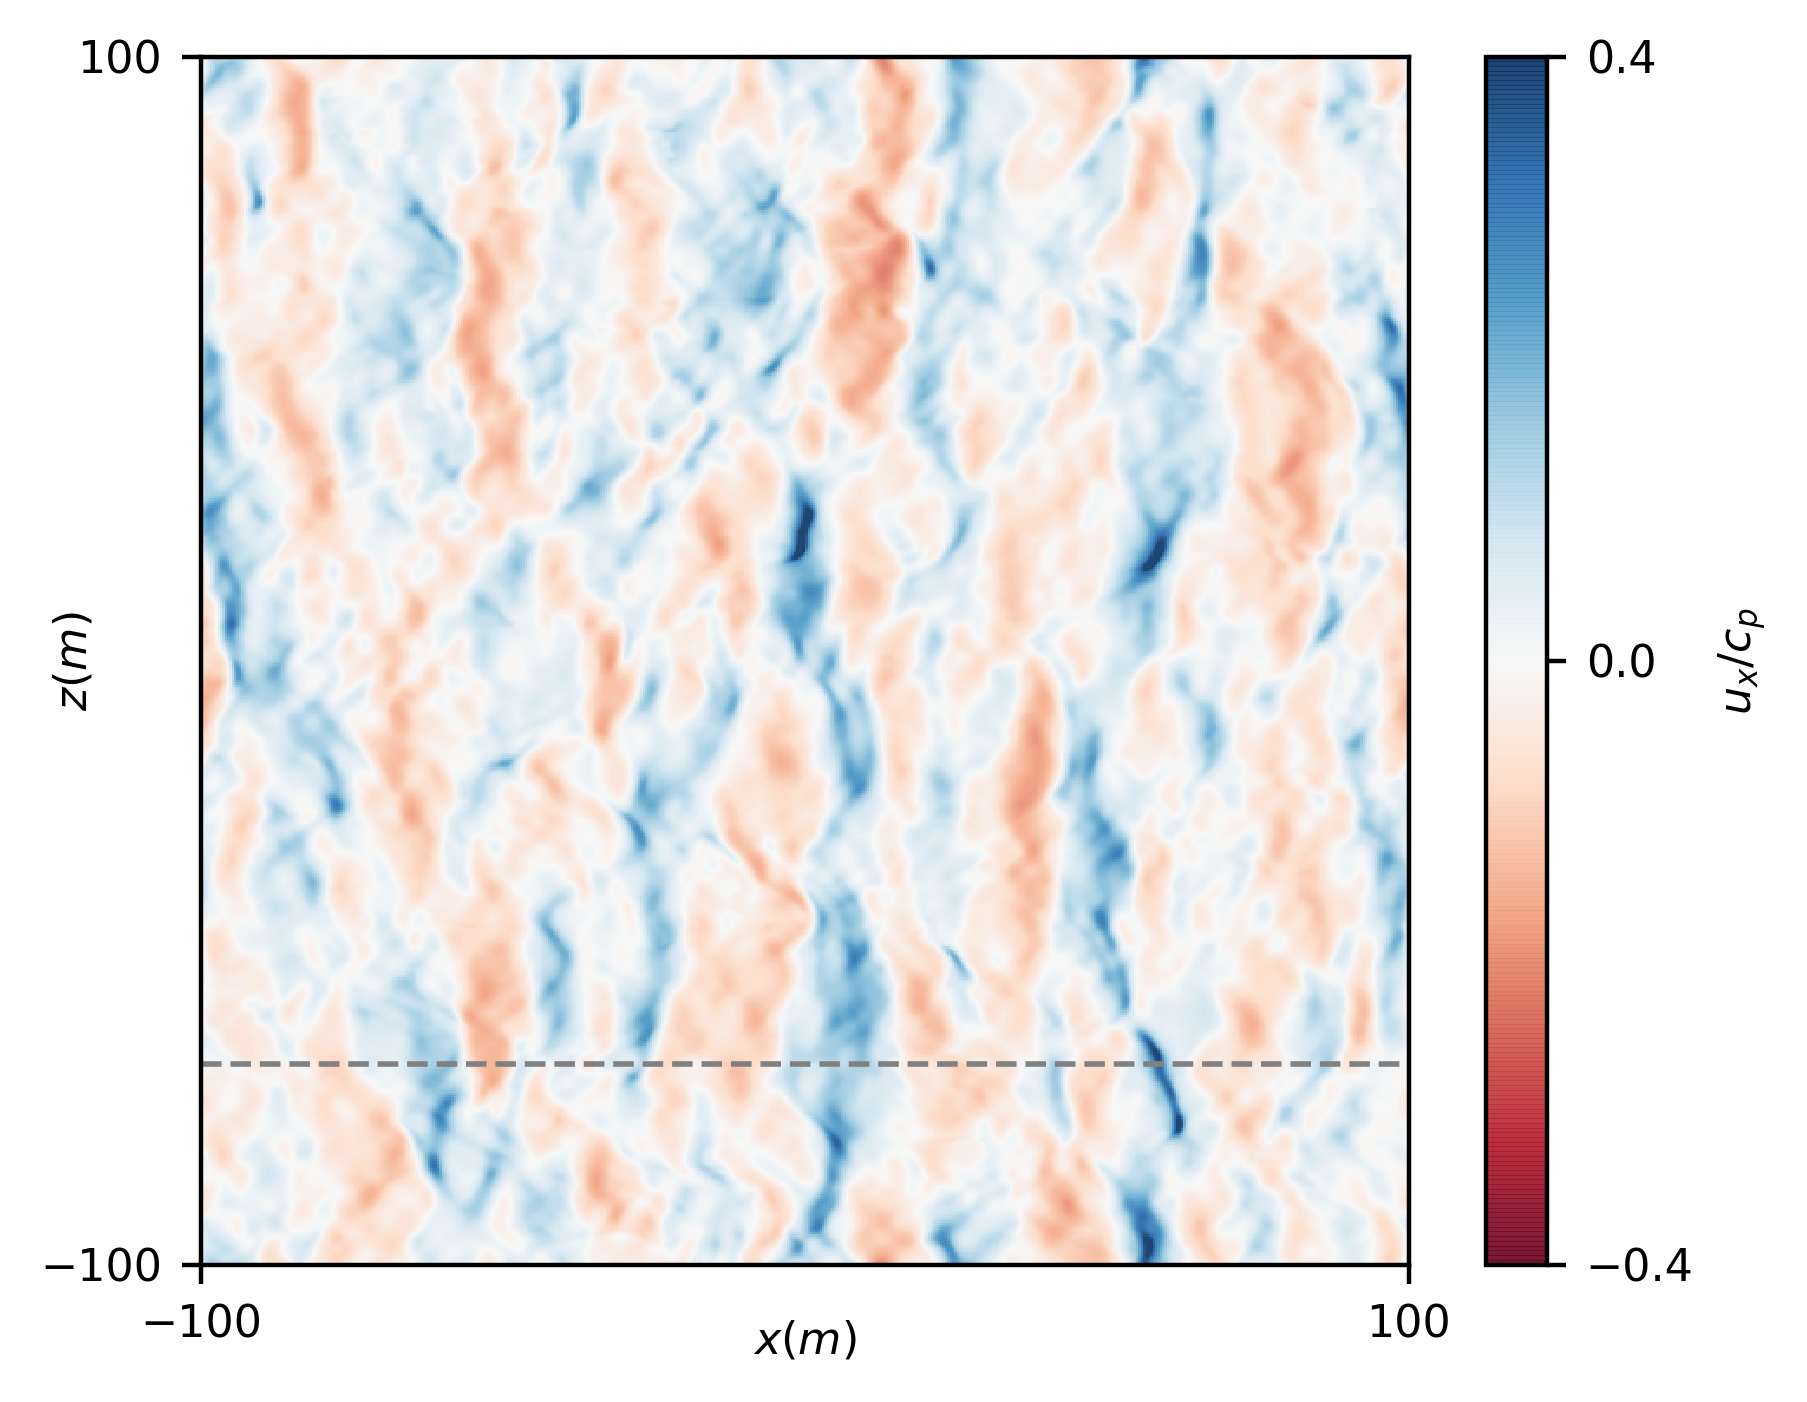

In [131]:
fig = plt.figure(figsize=[5,4]); ax = plt.gca()
L = 200
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 

image = ax.imshow(np.rot90(case_field1.ux_ensem[-1,:,:])/cp, extent=[-L/2,L/2,-L/2,L/2], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)
# image = ax.imshow(case_field1.ux_ensem[-1,:,:]/cp, extent=[-L/2,L/2,-L/2,L/2], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)

ax.set_xticks([-L/2,L/2]); ax.set_yticks([-L/2,L/2])

v1 = np.linspace(-0.4, 0.4, 3, endpoint=True)
cbar = fig.colorbar(image, orientation="vertical", ticks=v1)

# x_ = np.linspace(-100,100,100)
# y_ = np.ones(100)*(220/512)*200-100
# plt.plot(x_, y_, c='gray')
x_ = np.linspace(-100,100,100)
y_ = np.ones(100)*(85/512)*200-100
plt.plot(x_, y_, '--', lw=1, c='gray')

cbar.set_label(r'$u_x/c_p$')
plt.xlabel('$x(m)$', labelpad=-5)
plt.ylabel('$z(m)$', labelpad=-10)
fig.savefig('figures_backup/bulk_velocity_topdown_pof.pdf', bbox_inches='tight')

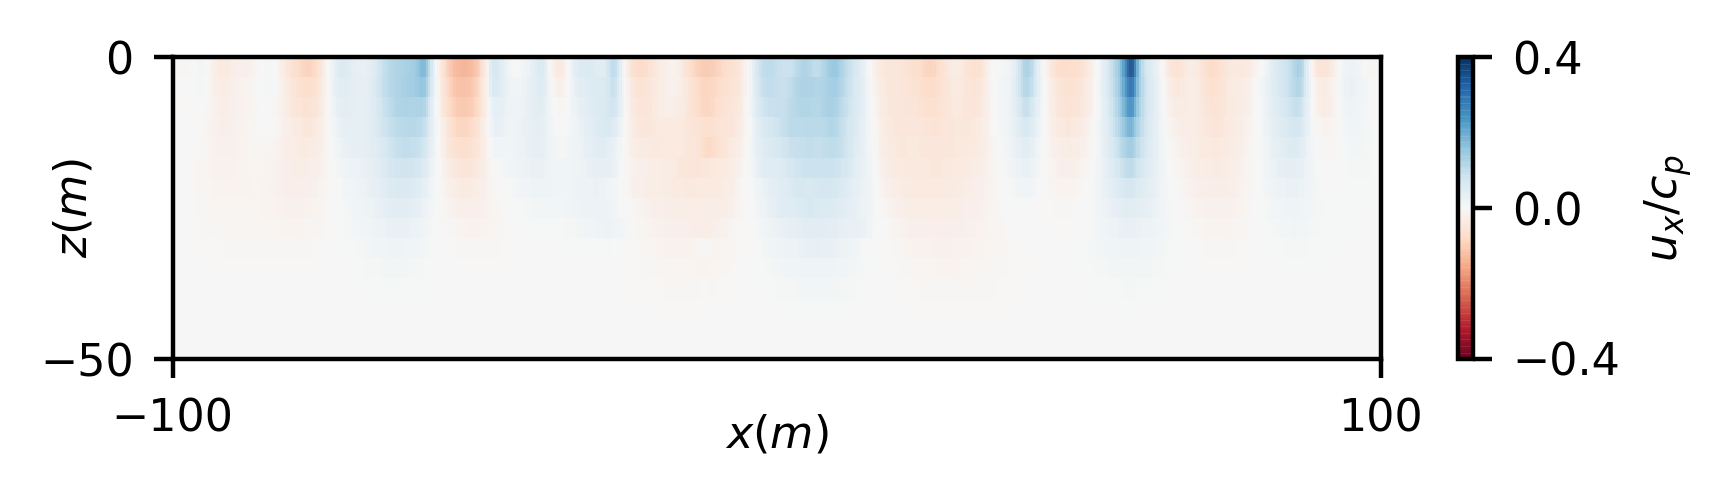

In [132]:
fig = plt.figure(figsize=[5,1]); ax = plt.gca()
L = 200
kp = 2*np.pi/L*5; cp = (9.8/kp)**0.5 

case_field1.ux_ensem[0,:,:] = case_field1.ux_ensem[0,:,:]*0 # THIS IS NOT GOOD BUT WE REMOVED THE BOTTOM LINE ANOMALY
image = ax.imshow(case_field1.ux_ensem[::-1,:,85]/cp, extent=[-L/2,L/2,-50,0], vmax=0.4, vmin=-0.4, cmap='RdBu', alpha=0.9)
ax.set_xticks([-L/2,L/2]); ax.set_yticks([-50,0])

v1 = np.linspace(-0.4, 0.4, 3, endpoint=True)
cbar = fig.colorbar(image, orientation="vertical", ticks=v1)

cbar.set_label(r'$u_x/c_p$')
plt.xlabel('$x(m)$', labelpad=-5)
plt.ylabel('$z(m)$', labelpad=-10)
fig.savefig('figures_backup/bulk_velocity_pof.pdf', bbox_inches='tight')

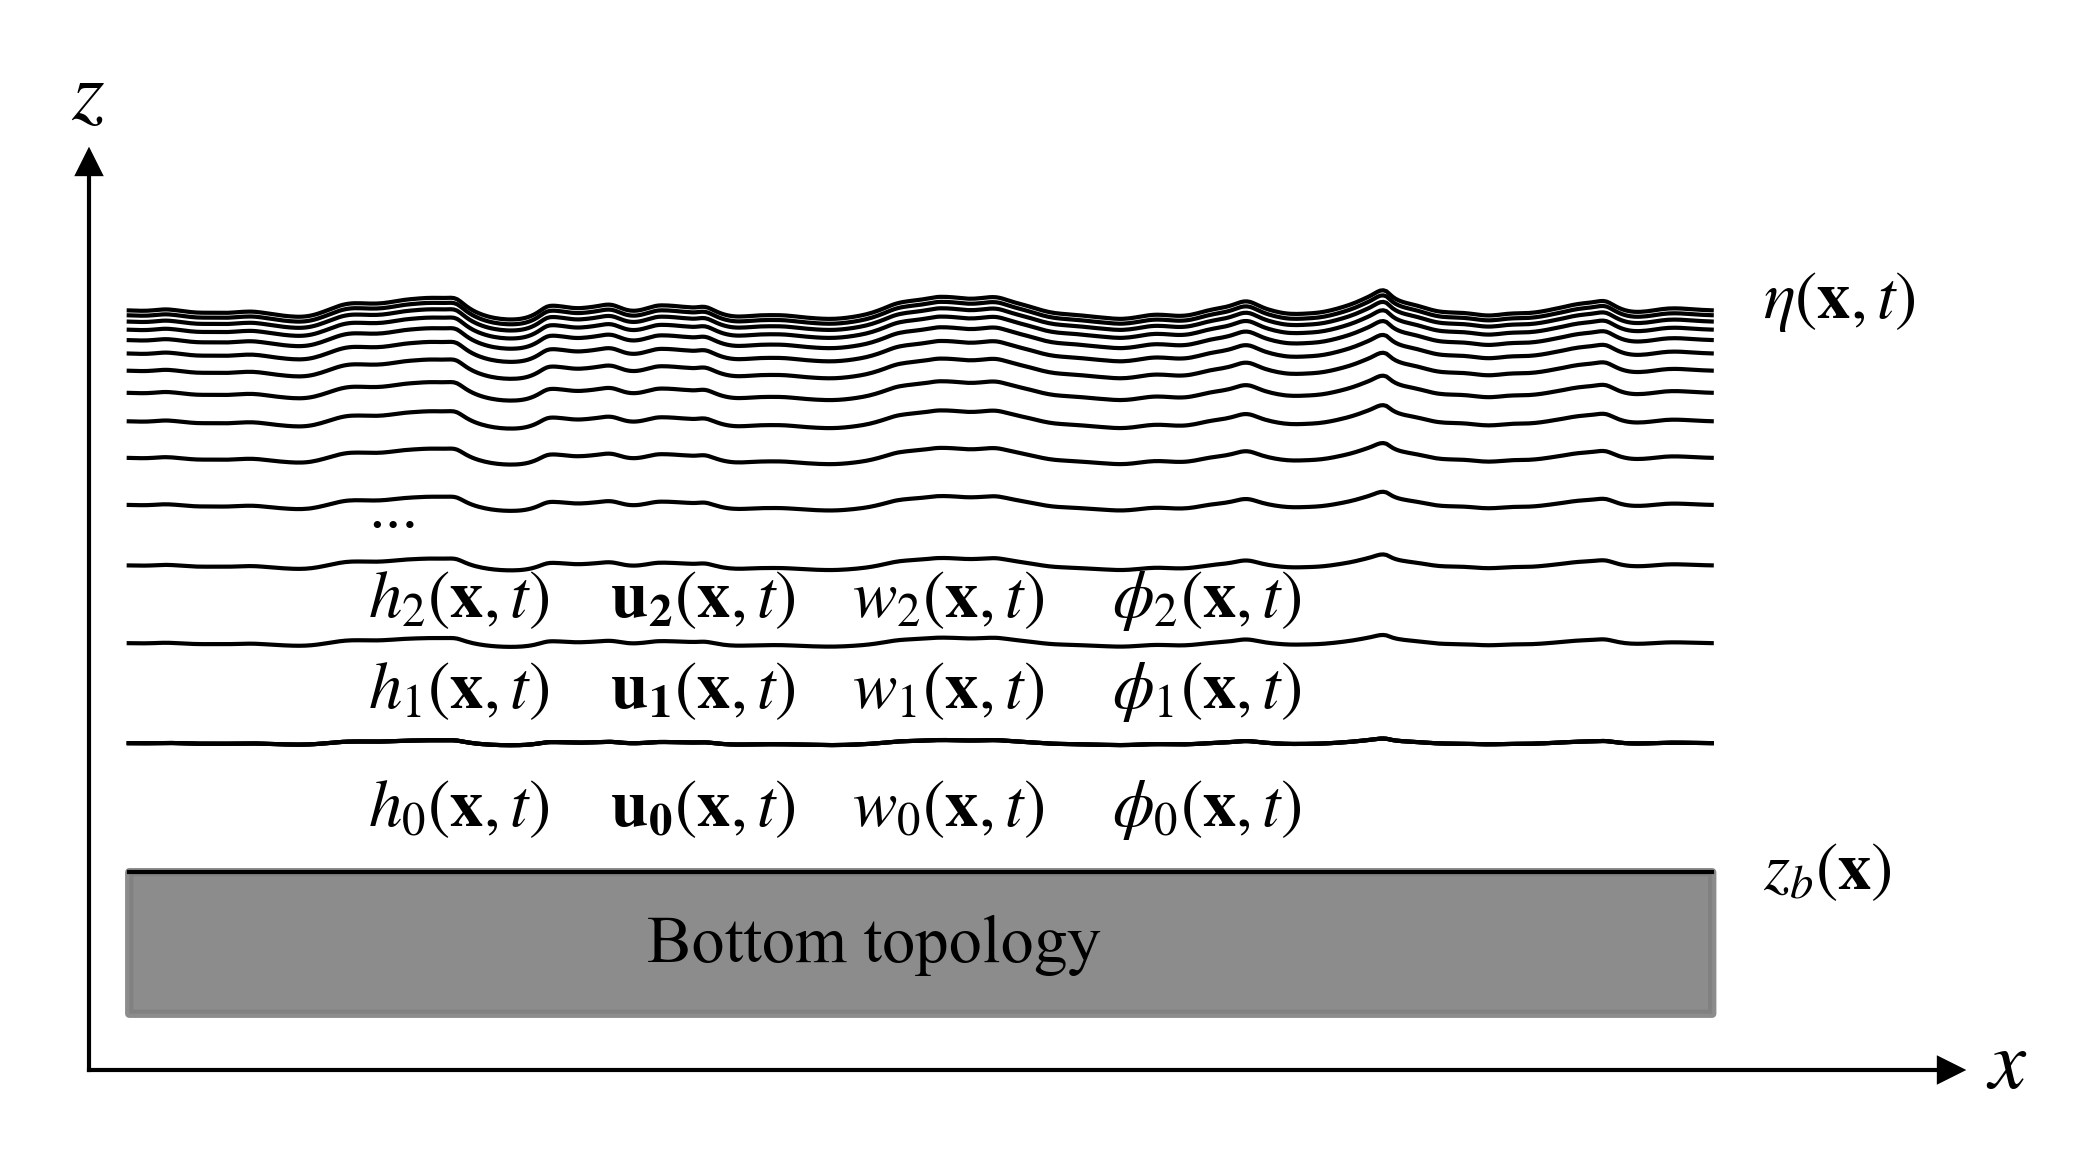

In [103]:
fig = plt.figure(figsize=[4,2]); ax = plt.gca()
x_ = np.linspace(-100,100,512)
sl = 85
h_bottom = case_field1.h_ensem[1,:,sl]*case_field1.h_ensem[1,:,sl]/case_field1.h_ensem[2,:,sl]
# eta = np.sum(case_field1.h_ensem[:,:,sl],axis=0)+h_bottom-40
# plt.plot(x_, eta)

plt.plot(x_, np.sum(case_field1.h_ensem[1:-1,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-2,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-3,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-4,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-5,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-6,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-7,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-8,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-9,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-10,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-11,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-12,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-13,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-14,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-15,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, h_bottom-40, lw=0.5, c='k')
plt.plot(x_, h_bottom*0-40, lw=0.5, c='k')
plt.ylim([-54,10])
plt.xlim([-105,130])


ax.fill_between(x_, h_bottom*0-50, h_bottom*0-40, color='gray', alpha=0.9)

# Move the left and bottom spines to x = 0 and y = 0, respectively.
# ax.spines[["left", "bottom"]].set_position(("data", 0))
# Hide the top and right spines.
ax.spines[["top", "right"]].set_visible(False)

# Draw arrows (as black triangles: ">k"/"^k") at the end of the axes.  In each
# case, one of the coordinates (0) is a data coordinate (i.e., y = 0 or x = 0,
# respectively) and the other one (1) is an axes coordinate (i.e., at the very
# right/top of the axes).  Also, disable clipping (clip_on=False) as the marker
# actually spills out of the axes.
ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False, markersize=2)
ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False, markersize=2)
# ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.text(1.02, -0.02, '$x$', transform=ax.transAxes, clip_on=False)
ax.text(-0.01, 1.05, '$z$', transform=ax.transAxes, clip_on=False)
ax.text(0.3, 0.12, 'Bottom topology', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.9, 0.83, r'$\eta(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.9, 0.2, r'$z_{b}(\mathbf{x})$', transform=ax.transAxes, clip_on=False, fontsize=8)

ax.text(0.15, 0.27, r'$h_0(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.28, 0.27, r'$\mathbf{u_{0}}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.41, 0.27, r'$w_{0}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.55, 0.27, r'$\phi_{0}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.15, 0.4, r'$h_1(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.28, 0.4, r'$\mathbf{u_{1}}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.41, 0.4, r'$w_{1}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.55, 0.4, r'$\phi_{1}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.15, 0.5, r'$h_2(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.28, 0.5, r'$\mathbf{u_{2}}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.41, 0.5, r'$w_{2}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.55, 0.5, r'$\phi_{2}(\mathbf{x},t)$', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.text(0.15, 0.6, r'...', transform=ax.transAxes, clip_on=False, fontsize=8)
ax.set_xticks([]); ax.set_yticks([])

fig.savefig('figures/sketch_ml.pdf', bbox_inches='tight')

Text(0, 0.5, '$z$')

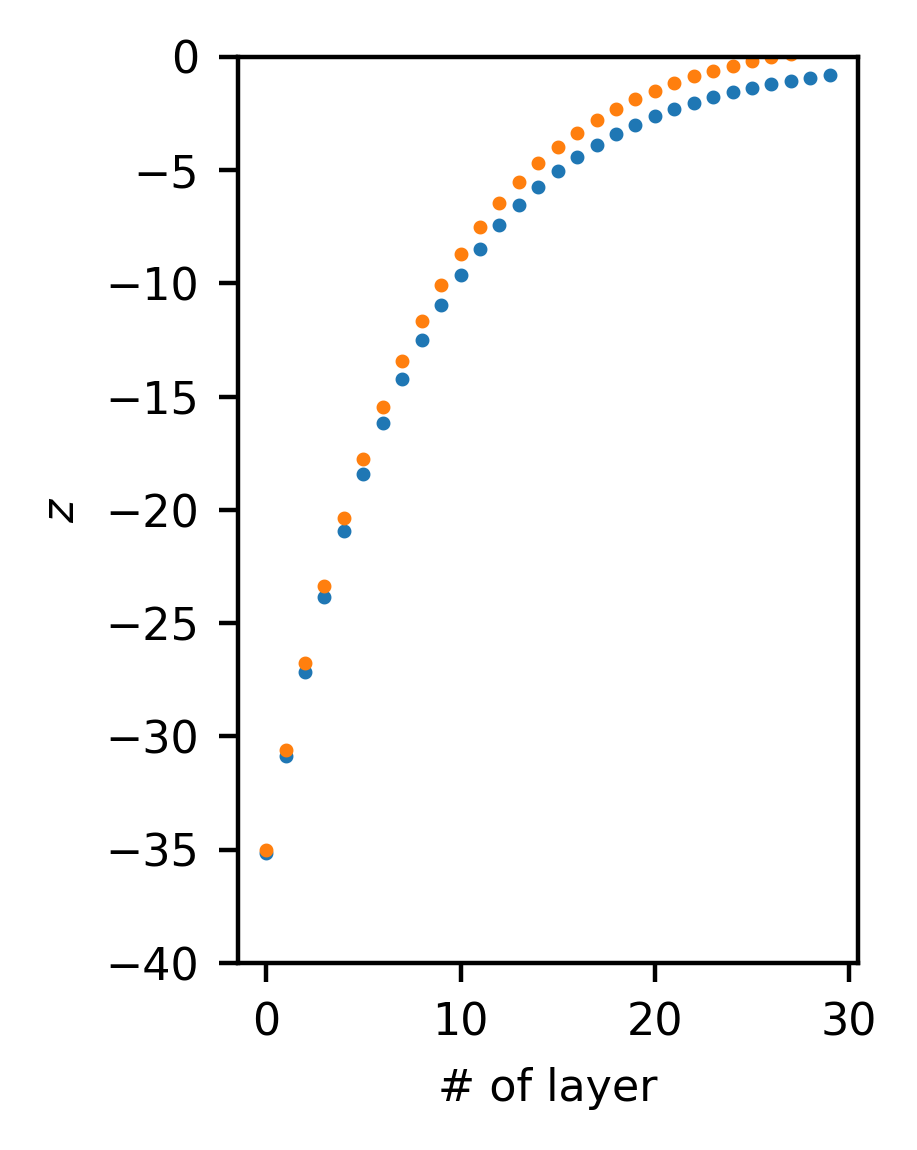

In [97]:
fig = plt.figure(figsize=[2,3])
case = case_field1
# h_aver = np.average(case.h_ensem, axis=(1,2))
h_aver = case.h_ensem[:,85,85]
h_aver[0] = h_aver[1]*h_aver[1]/h_aver[2] # Because of the first layer not detected...
z_aver = np.zeros(len(h_aver))
for i in range(len(z_aver)):
    z_aver[i] = np.sum(h_aver[0:i+1]) 

plt.plot(z_aver-40,'.',markersize=3)

h_aver = case.h_ensem[:,400,85]
h_aver[0] = h_aver[1]*h_aver[1]/h_aver[2] # Because of the first layer not detected...
z_aver = np.zeros(len(h_aver))
for i in range(len(z_aver)):
    z_aver[i] = np.sum(h_aver[0:i+1]) 
plt.plot(z_aver-40,'.',markersize=3)

# plt.plot(np.var(h_ensem, axis=(1,2))**0.5,'.')
# plt.plot(np.average(ux_ensem, axis=(1,2)),'.')
# plt.xlim([0,30])
plt.ylim([-40,0])
plt.xlabel('# of layer')
plt.ylabel(r'$z$')

In [ ]:
h_bottom = case_field1.h_ensem[1,:,sl]*case_field1.h_ensem[1,:,sl]/case_field1.h_ensem[2,:,sl]
# eta = np.sum(case_field1.h_ensem[:,:,sl],axis=0)+h_bottom-40
# plt.plot(x_, eta)

plt.plot(x_, np.sum(case_field1.h_ensem[1:-1,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-2,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-3,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-4,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-5,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-6,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-7,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-8,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-9,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-10,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-11,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-12,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-13,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-14,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, np.sum(case_field1.h_ensem[1:-15,:,sl],axis=0)+h_bottom-40, lw=0.5, c='k')
plt.plot(x_, h_bottom-40, lw=0.5, c='k')
plt.plot(x_, h_bottom*0-40, lw=0.5, c='k')
plt.ylim([-54,10])
plt.xlim([-105,130])

In [5]:
h_ensem.shape

ux_ensem, uy_ensem, uz_ensem

(15, 512, 512)

In [7]:
case_field1.h_ensem[0,:,:] = case_field1.h_ensem[1,:,:]*case_field1.h_ensem[1,:,:]/case_field1.h_ensem[2,:,:]
h_ensem[0,:,:] = h_ensem[1,:,:]*h_ensem[1,:,:]/h_ensem[2,:,:]
# field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503
case_field1.L0 = 200 # Box size
case_field1.H = 40 # Depth

In [17]:
""" Writing to csv """
import csv
file = open("multilayer.csv", "w")
fieldnames = ['x', 'y', 'z', 'ux', 'uy', 'uz', 'f']
writer = csv.writer(file)
writer.writerow(fieldnames) 

z_ensem = h_ensem*0
f_ensem = h_ensem*0

case = case_field1

xarray = np.linspace(-case.L0/2, case.L0/2, 512)
yarray = np.linspace(-case.L0/2, case.L0/2, 512)

for k in range(15):
    for i in range(512):
        for j in range(512):
            z_ensem[k,i,j] = np.sum(h_ensem[:k,i,j]) + 0.5*h_ensem[k,i,j] - case.H
            if k == 14: # surface layer
                f_ensem[k,i,j] = 0
            else:
                f_ensem[k,i,j] = 1
            writer.writerow([xarray[i], yarray[j], z_ensem[k,i,j], ux_ensem[k,i,j], uy_ensem[k,i,j], uz_ensem[k,i,j], f_ensem[k,i,j]])     

file.close()

In [9]:
""" Compute the arrays without writing to csv yet """

fieldnames = ['x', 'y', 'z', 'ux', 'uy', 'uz', 'f']

z_ensem = h_ensem*0
f_ensem = h_ensem*0
x_ensem = h_ensem*0
y_ensem = h_ensem*0


case = case_field1

xarray = np.linspace(-case.L0/2, case.L0/2, 512)
yarray = np.linspace(-case.L0/2, case.L0/2, 512)

for k in range(15):
    for i in range(512):
        for j in range(512):
            z_ensem[k,i,j] = np.sum(h_ensem[:k,i,j]) + 0.5*h_ensem[k,i,j] - case.H
            x_ensem[k,i,j] = xarray[i]
            y_ensem[k,i,j] = yarray[j]
            if k == 14: # surface layer
                f_ensem[k,i,j] = 0
            else:
                f_ensem[k,i,j] = 1


In [63]:
""" Compute the arrays without writing to csv yet """

fieldnames = ['x', 'y', 'z', 'ux', 'uy', 'uz', 'f']

x_vtk = np.zeros([513,513,16])
y_vtk = np.zeros([513,513,16])
z_vtk = np.zeros([513,513,16])
f_vtk = np.zeros([512,512,15])
ux_vtk = np.zeros([512,512,15])
uy_vtk = np.zeros([512,512,15])
uz_vtk = np.zeros([512,512,15])

h_ensem_expand = np.zeros([15,513,513]) # Need to go from centered to grid, pad the array
h_ensem_expand[:,:512,:512] = np.copy(h_ensem) # Need to go from centered to grid
h_ensem_expand[:,512,:512] = np.copy(h_ensem[:,511,:512])
h_ensem_expand[:,:512,512] = np.copy(h_ensem[:,:512,511])
h_ensem_expand[:,512,512] = np.copy(h_ensem[:,511,511])
h_ensem_expand = np.array(h_ensem_expand)

case = case_field1

xarray = np.linspace(-case.L0/2, case.L0/2, 513, endpoint=True)
yarray = np.linspace(-case.L0/2, case.L0/2, 513, endpoint=True)

for k in range(16):
    for i in range(513):
        for j in range(513):
            z_vtk[i,j,k] = np.sum(h_ensem_expand[:k,i,j]) - case.H
            x_vtk[i,j,k] = xarray[i]
            y_vtk[i,j,k] = yarray[j]
                
for k in range(15):
    for i in range(512):
        for j in range(512):
            ux_vtk[i,j,k] = ux_ensem[k,i,j]
            uy_vtk[i,j,k] = uy_ensem[k,i,j]
            uz_vtk[i,j,k] = uz_ensem[k,i,j]
            if k == 14: # surface layer
                f_vtk[i,j,k] = 0
            else:
                f_vtk[i,j,k] = 1

In [42]:
from pyevtk.hl import gridToVTK

In [64]:
# gridToVTK("./structured", x, y, z, cellData = {"pressure" : pressure}, pointData = {"temp" : temp})
# gridToVTK("./structured", x_ensem, y_ensem, z_ensem, cellData = {"f" : f_ensem, "ux": ux_ensem, "uy": uy_ensem, "uz":uz_ensem})
gridToVTK("./structured1", x_vtk, y_vtk, z_vtk, cellData = {"f" : f_vtk, "ux": ux_vtk, "uy": uy_vtk, "uz":uz_vtk})


'/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/project_specific/multilayer/structured1.vts'